In [33]:
from massimal.hyspec_io import load_envi_image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.decomposition import PCA

In [25]:
# hdr_path = Path(r'C:\Users\mha114\Dropbox\Python\massimal\dataset_specific\20220825_Vega_Sola\StudySpectralChangeWithDepth\sound3b_18_sand\Vega_SolaNW_Sound3b_Pika_L_18.bil-Average-SGFilter-spec-0.spec.hdr')
# spec_path = Path(r'C:\Users\mha114\Dropbox\Python\massimal\dataset_specific\20220825_Vega_Sola\StudySpectralChangeWithDepth\sound3b_18_sand\Vega_SolaNW_Sound3b_Pika_L_18.bil-Average-SGFilter-spec-0.spec')
spec_dir = Path(r'C:\Users\mha114\Dropbox\Python\massimal\dataset_specific\20220825_Vega_Sola\StudySpectralChangeWithDepth\sound3b_18_sand')


In [76]:
wl_upper_limit = 720
wl_lower_limit = 420

In [77]:
# Load spectra and limit wavelengths to range with high enough SNR
X = []
for hdr_path in spec_dir.glob('*.hdr'):
    spec, wl, _, metadata =  load_envi_image(hdr_path)
    spec = np.squeeze(spec,axis=0)
    X.append(spec)
X = np.concatenate(X)

wl_ind = (wl>wl_lower_limit) & (wl<wl_upper_limit)
wl = wl[wl_ind]
X = X[:,wl_ind]
print(X.shape)


(11, 144)


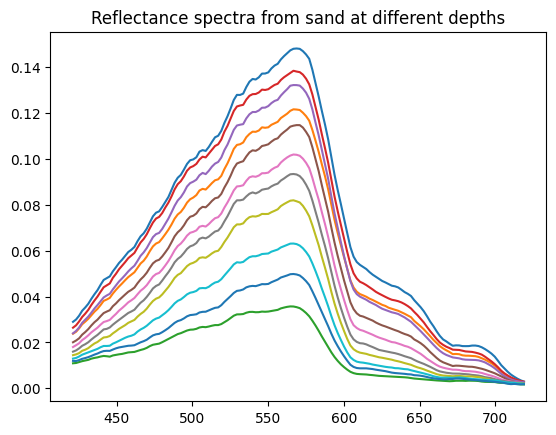

In [98]:
# Plot spectra
for spec in X:
    plt.plot(wl,spec)
plt.title('Reflectance spectra from sand at different depths')
plt.show()

The spectra seem to have a "baseline" which is non-zero for short wavelengths and close to zero for longer wavelengths. A plausible cause of this is sky glint, which is dominated by blue light. We can estimate the baseline as a linear function and try to remove it: 

[]

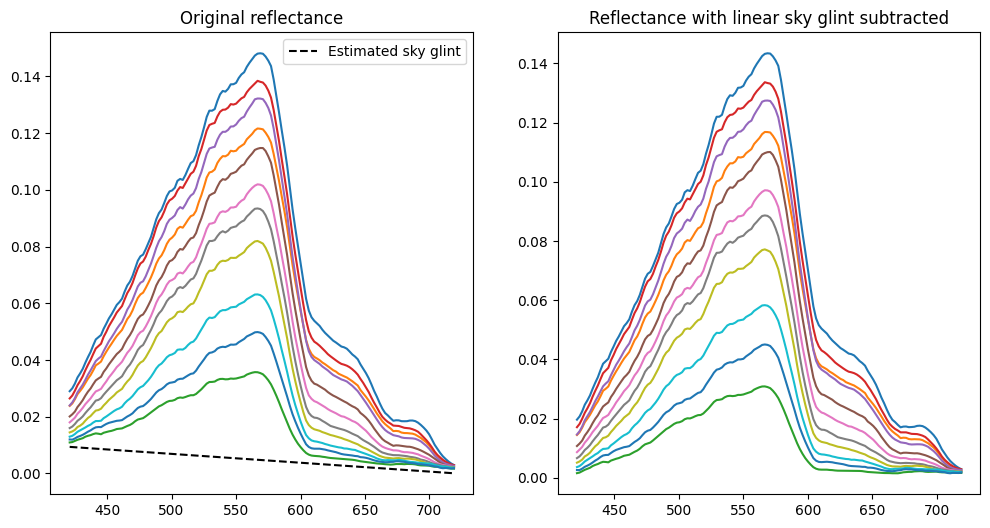

In [96]:
# Define point for approximate scattering / sky glint contribution
x = [400, 720]
y = [0.01, 0]

# Calculate the coefficients and corresponding polynomial
coefficients = np.polyfit(x, y, 1)
polynomial = np.poly1d(coefficients)

# Compute scattering line
spec_scatt = polynomial(wl)

# Remove scattering offset
X_no_scatt = X - spec_scatt

# Plot with other
fig, ax = plt.subplots(ncols=2,figsize=(12,6))
for spec in X:
    ax[0].plot(wl,spec)
ax[0].plot(wl,spec_scatt,'k--',label=('Estimated sky glint'))
ax[0].legend()
ax[0].set_title('Original reflectance')

for spec in X_no_scatt:
    ax[1].plot(wl,spec)
ax[1].set_title('Reflectance with linear sky glint subtracted')
plt.plot()


It is interesting to study how the variation can be modelled as principal components:

In [80]:
pca = PCA(n_components=8)
X_pca = pca.fit_transform(X_no_scatt)

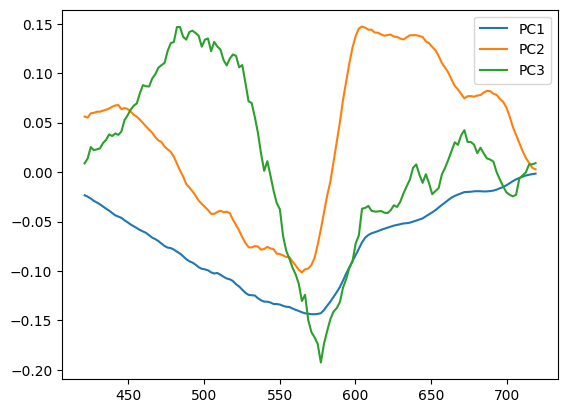

In [81]:
for i in range(3):
    plt.plot(wl,pca.components_[i],label=f'PC{i+1}')
    plt.legend()

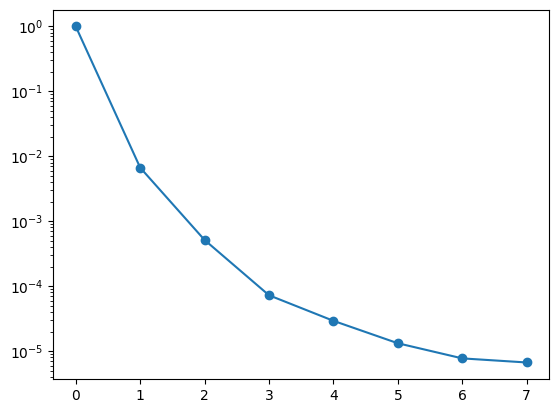

In [101]:
plt.semilogy(pca.explained_variance_ratio_,'o-')
plt.show()

Note that the first component explains more than 2 orders of magnitude more variance than the second one! 

Now let's try to study the logarithmic spectra. If the original spectra have follow a exponential relationship given by
$ R = R_0 \cdot \exp(-2Kz) $,

then taking the logarithm should result in
$\log(R) = \log(R_0) - 2K(\lambda)z $

... and if R_0 is constant (same spectral class, e.g. sand), then $K(z)$ should be proportional to the first principal component.


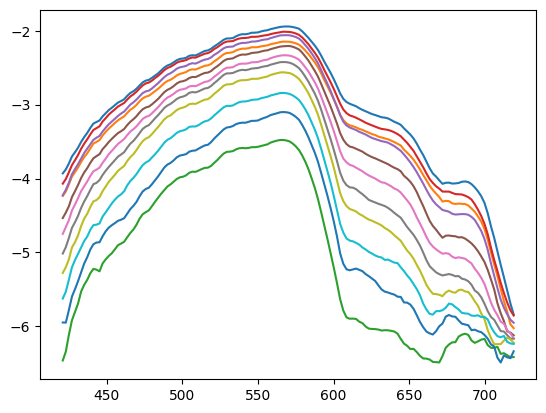

In [82]:
X_log = np.log(X_no_scatt)
for spec in X_log:
    plt.plot(wl,spec)

In [102]:
pca_log = PCA(n_components=8)
X_pca = pca_log.fit_transform(X_log)

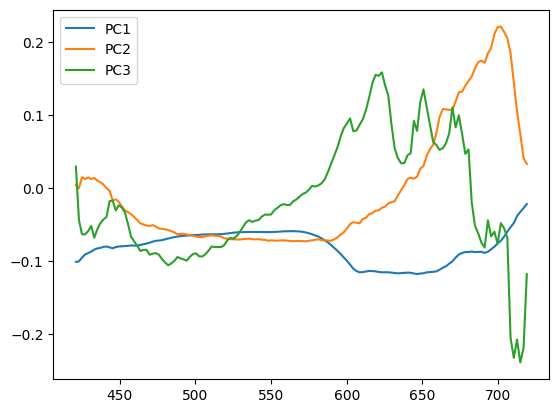

In [103]:
for i in range(3):
    plt.plot(wl,pca_log.components_[i],label=f'PC{i+1}')
    plt.legend()

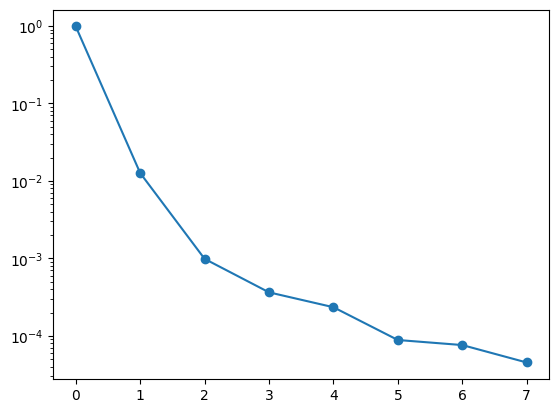

In [106]:
plt.semilogy(pca_log.explained_variance_ratio_,'o-')
plt.show()

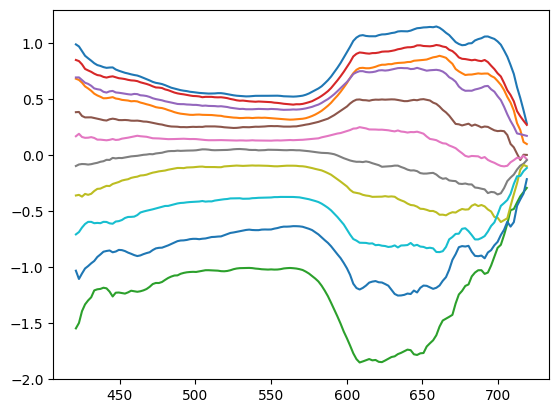

In [105]:
for spec in X_log:
    plt.plot(wl,spec-pca_log.mean_)

[]

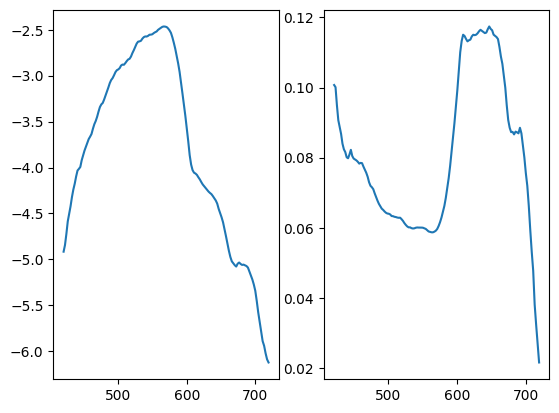

In [90]:
fig,ax = plt.subplots(ncols=2)
ax[0].plot(wl,pca_log.mean_)
ax[1].plot(wl,pca_log.components_[0])
plt.plot()

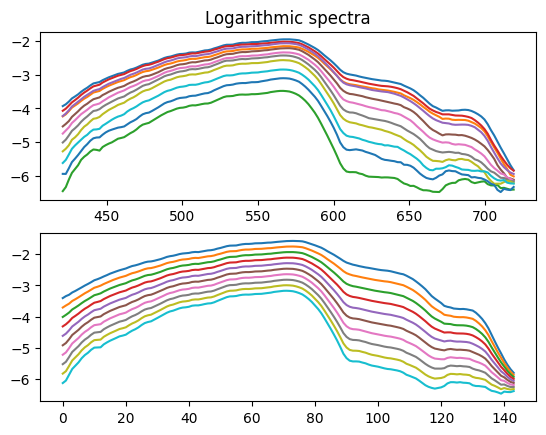

In [115]:
fig,ax = plt.subplots(nrows=2)

for spec in X_log:
    ax[0].plot(wl,spec)
ax[0].set_title('Logarithmic spectra')

scale = 3
for i in range(-5,5):
    ax[1].plot(pca_log.mean_ + scale*i*pca_log.components_[0])